<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Заключение

* Был проведен анализ данных от 01.04.2015 до 10.04.2024 
* с помошью 'Prophet' был проведен прогноз и построенные соответствующие графики трендов и прогноза.

    - Построенные модели отдельно для каждого гаджета:
    
        1. Смартфоны: для тренировки модели был выбран диапазон до 01.01.2022 ошибка 8%
        2. Десктопы: для тренировки модели был выбран диапазон до 01.01.2023 ошибка 9%
        3. Планшеты: для тренировки модели был выбран диапазон до 01.01.2023 ошибка 13%
        
    - Была получена доля для смартофонов на 2025 равной 71%    
    - Была получена доля для смартофонов на 2027 равной 75%
    
Код с помощью которого был проведен анализ и прогноз приведен ниже

# Код

In [1]:
from prophet import Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

data = pd.read_csv('datasets\data_3.csv', 
                                 sep=';',
                           index_col=[0])
data.head()

,"Планшеты, Визиты","Планшеты, Доля","Десктоп, Визиты","Десктоп, Доля","Смартфоны, Визиты","Смартфоны, Доля"
Время,,,,,,
01.04.2015,45393051,0.077597,447343137,0.764711,92247061,0.157692
02.04.2015,45102541,0.077583,444583225,0.764751,91658108,0.157666
03.04.2015,42930018,0.077570,422696646,0.763770,87807772,0.158660
04.04.2015,45493492,0.098185,333831204,0.720478,84022173,0.181338
05.04.2015,50647356,0.100921,362232345,0.721791,88972415,0.177288


In [2]:
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')

# Смартфоны

In [3]:

from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):

    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='Смартфоны, Визиты')
features_and_target = pd.concat([X, y], axis=1)

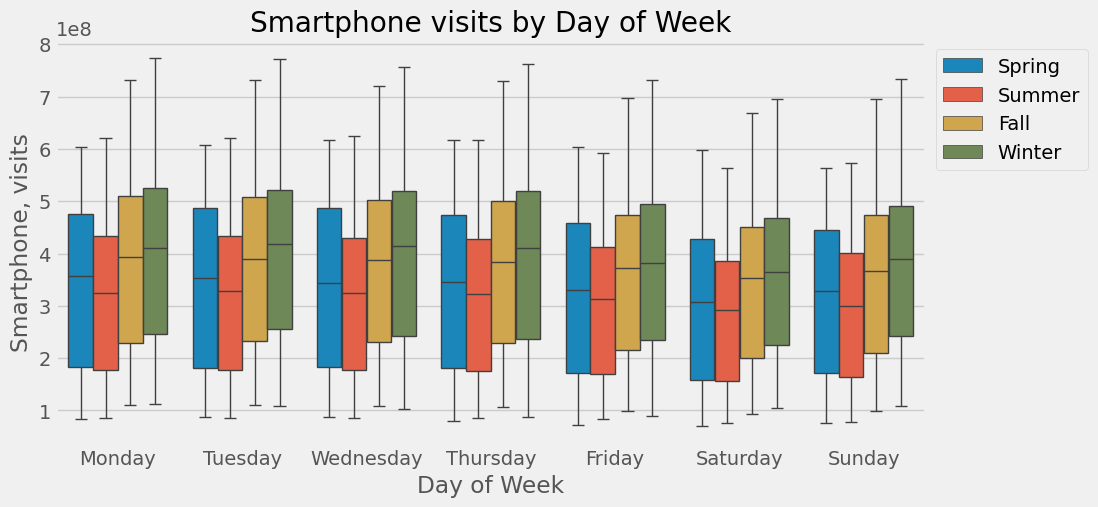

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Смартфоны, Визиты',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Smartphone visits by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Smartphone, visits')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [5]:
data_visits = data.loc[:, ['Планшеты, Визиты', 'Десктоп, Визиты', 'Смартфоны, Визиты']]

<Axes: title={'center': 'Визиты'}, xlabel='Время'>

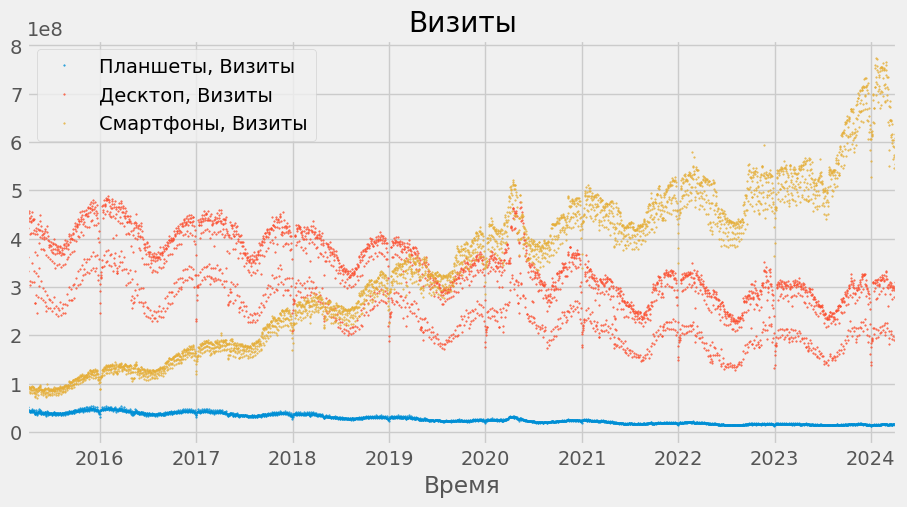

In [6]:
data_visits.plot(style='.',
          figsize=(10, 5),
          ms=1,
          title='Визиты')

In [7]:
data_visits_smartphone = data_visits.loc[:, 'Смартфоны, Визиты']

split_date = '01.01.2022'

data_train = data_visits_smartphone.loc[data_visits_smartphone.index <= split_date].copy()
data_test = data_visits_smartphone.loc[data_visits_smartphone.index > split_date].copy()

# Plot train and test so you can see where we have split
data_visits_smartphone_train = data_visits_smartphone.loc[data_visits_smartphone.index <= split_date].copy()
data_visits_smartphone_test = data_visits_smartphone.loc[data_visits_smartphone.index > split_date].copy()

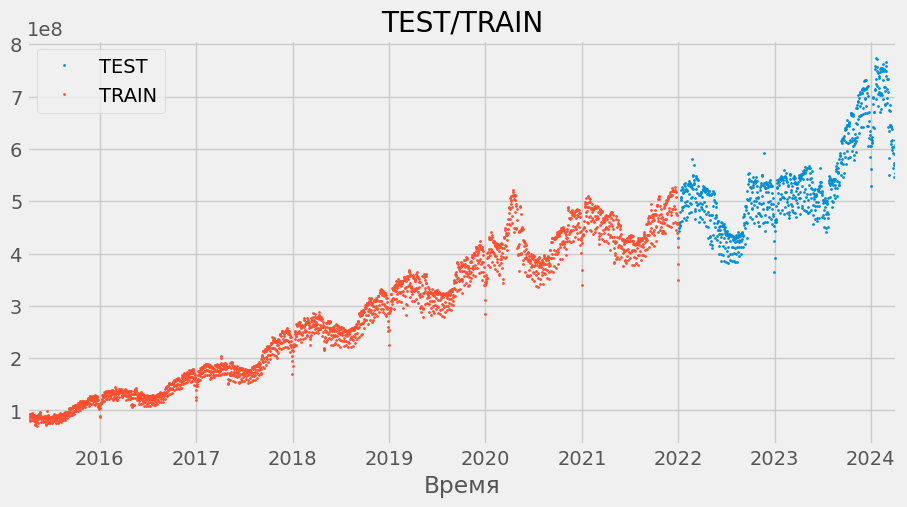

In [8]:
# Plot train and test so you can see where we have split
data_visits_smartphone_test.name = 'TEST'
data_visits_smartphone_train.name = 'TRAIN'

data_visits_smartphone_test \
    .to_frame() \
    .join(data_visits_smartphone_train, 
          how='outer').plot(figsize=(10, 5), title='TEST/TRAIN', style='.', ms=2)

plt.legend()
plt.show()

In [9]:
data_visits_smartphone_train_prophet = data_visits_smartphone_train.reset_index() \
    .rename(columns={'Время':'ds',
                     'TRAIN':'y'})
model1 = Prophet(holidays_prior_scale=0.001)
model1.add_country_holidays(country_name='RU')
model1.fit(data_visits_smartphone_train_prophet)

17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:10 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
data_visits_smartphone_test_prophet = data_visits_smartphone_test.reset_index() \
    .rename(columns={'Время':'ds',
                     'TEST':'y'})

data_visits_smartphone_test_fcst = model1.predict(data_visits_smartphone_test_prophet)

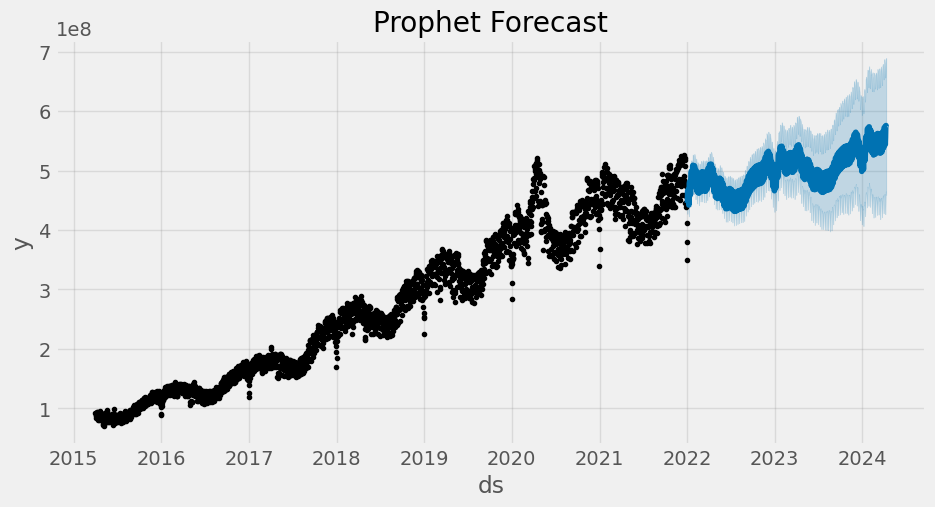

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model1.plot(data_visits_smartphone_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

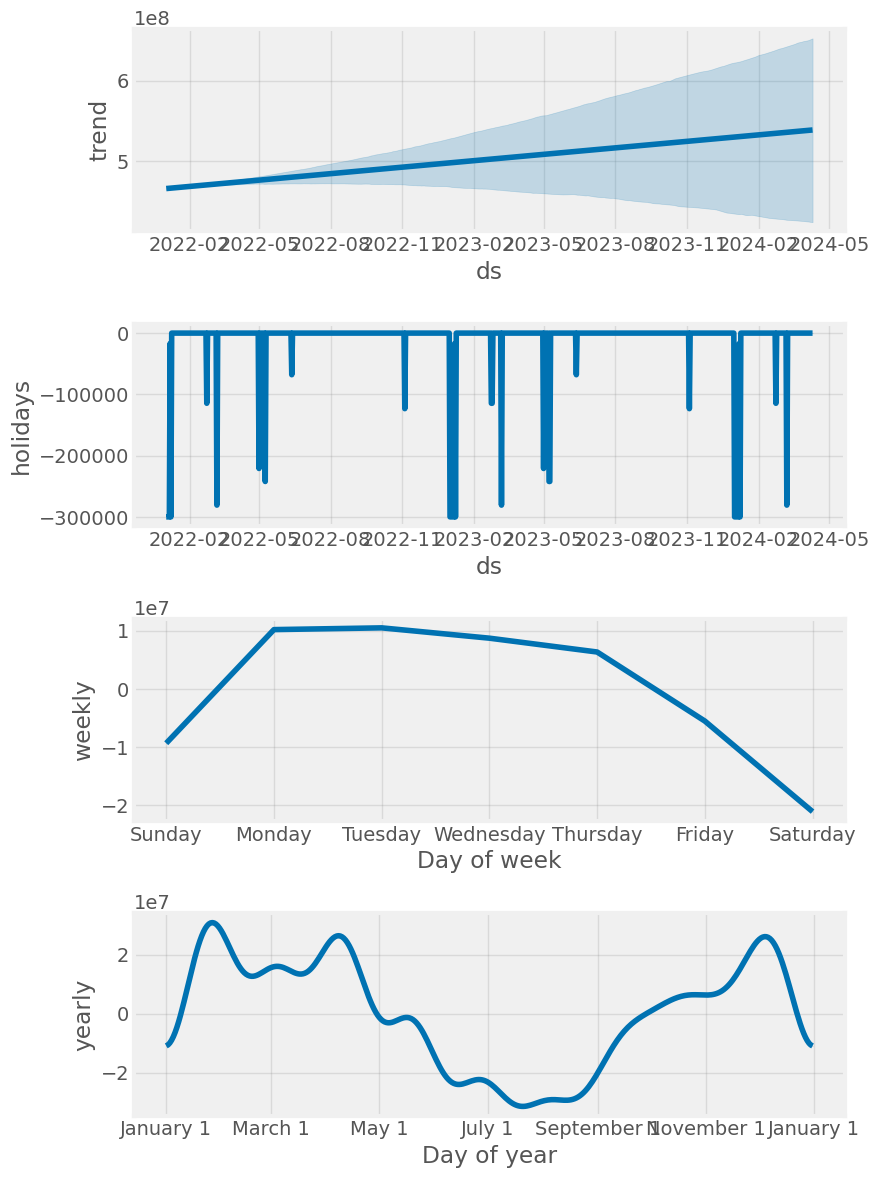

In [12]:
fig = model1.plot_components(data_visits_smartphone_test_fcst)
plt.show()

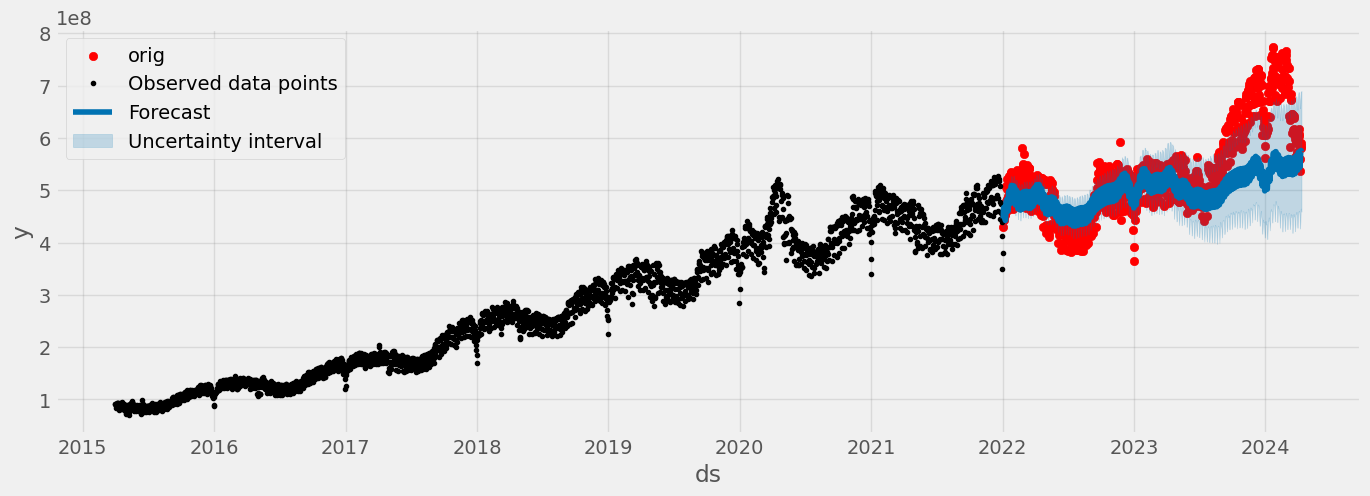

In [13]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_smartphone_test.index, data_visits_smartphone_test, color='r', label='orig')
fig = model1.plot(data_visits_smartphone_test_fcst, ax=ax)

plt.legend()

In [14]:
np.sqrt(mean_squared_error(y_true=data_visits_smartphone_test,
                   y_pred=data_visits_smartphone_test_fcst['yhat']))

69704422.23220937

In [15]:
mean_absolute_error(y_true=data_visits_smartphone_test,
                   y_pred=data_visits_smartphone_test_fcst['yhat'])

48023761.1857139

In [16]:
mean_absolute_percentage_error(y_true=data_visits_smartphone_test,
                   y_pred=data_visits_smartphone_test_fcst['yhat'])

8.101753879266209

In [17]:
future1 = model1.make_future_dataframe(periods=365*5, freq='d', include_history=False)
forecast1 = model1.predict(future1)

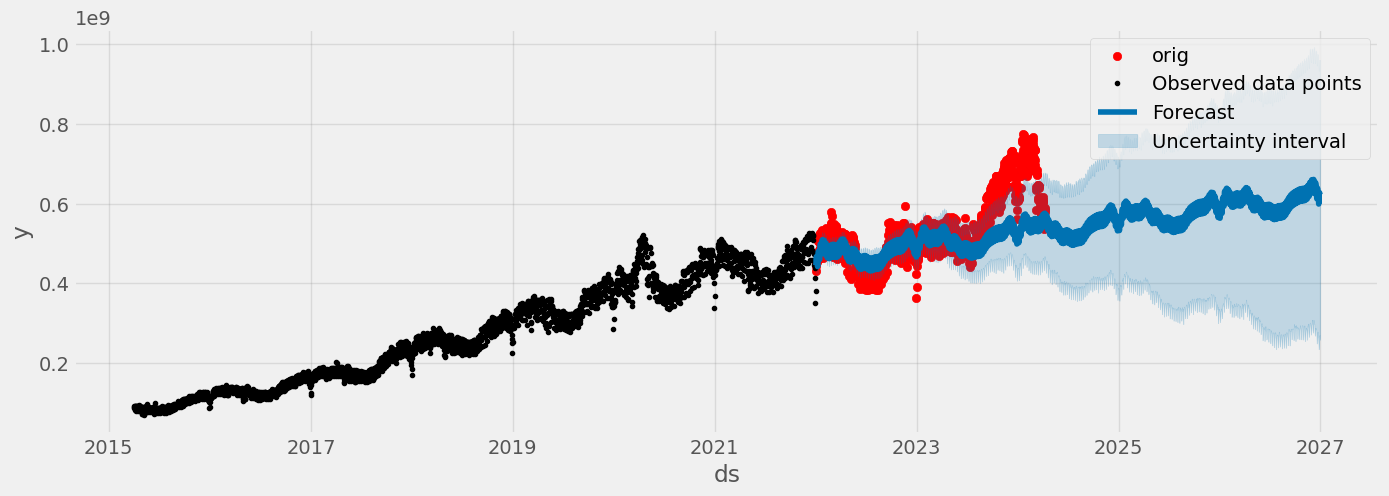

In [18]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_smartphone_test.index, data_visits_smartphone_test, color='r', label='orig')
fig = model1.plot(forecast1, ax=ax)

plt.legend()

In [19]:
forecast1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Fatherland Defender's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-02,4.661354e+08,4.262105e+08,4.651529e+08,4.661354e+08,4.661354e+08,0.0,0.0,0.0,0.0,...,-9.323906e+06,-9.323906e+06,-9.323906e+06,-1.066165e+07,-1.066165e+07,-1.066165e+07,0.0,0.0,0.0,4.458502e+08
1,2022-01-03,4.662233e+08,4.472411e+08,4.861794e+08,4.662233e+08,4.662233e+08,0.0,0.0,0.0,0.0,...,1.023930e+07,1.023930e+07,1.023930e+07,-1.009644e+07,-1.009644e+07,-1.009644e+07,0.0,0.0,0.0,4.660665e+08
2,2022-01-04,4.663112e+08,4.479896e+08,4.854264e+08,4.663112e+08,4.663112e+08,0.0,0.0,0.0,0.0,...,1.054046e+07,1.054046e+07,1.054046e+07,-9.240561e+06,-9.240561e+06,-9.240561e+06,0.0,0.0,0.0,4.673115e+08
3,2022-01-05,4.663992e+08,4.485135e+08,4.859480e+08,4.663992e+08,4.663992e+08,0.0,0.0,0.0,0.0,...,8.763233e+06,8.763233e+06,8.763233e+06,-8.104469e+06,-8.104469e+06,-8.104469e+06,0.0,0.0,0.0,4.667583e+08
4,2022-01-06,4.664871e+08,4.458012e+08,4.839548e+08,4.664871e+08,4.664871e+08,0.0,0.0,0.0,0.0,...,6.384126e+06,6.384126e+06,6.384126e+06,-6.703358e+06,-6.703358e+06,-6.703358e+06,0.0,0.0,0.0,4.658682e+08


In [20]:
#data_visits_smartphone_index = forecast1.loc[forecast1['ds'] == '2025-01-01'].index
data_visits_smartphone_2025 = forecast1.loc[forecast1['ds'] == '2025-01-01', 'yhat'].reset_index()
data_visits_smartphone_2027 = forecast1.loc[forecast1.shape[0] - 1, 'yhat']
data_visits_smartphone_2025
#data_visits_smartphone_index

,index,yhat
0,1095,5.599878e+08


# Десктопы

In [21]:
data_visits_desktop = data_visits.loc[:, 'Десктоп, Визиты']

split_date = '01.01.2023'

data_train = data_visits_desktop.loc[data_visits_desktop.index <= split_date].copy()
data_test = data_visits_desktop.loc[data_visits_desktop.index > split_date].copy()

# Plot train and test so you can see where we have split
data_visits_desktop_train = data_visits_desktop.loc[data_visits_desktop.index <= split_date].copy()
data_visits_desktop_test = data_visits_desktop.loc[data_visits_desktop.index > split_date].copy()

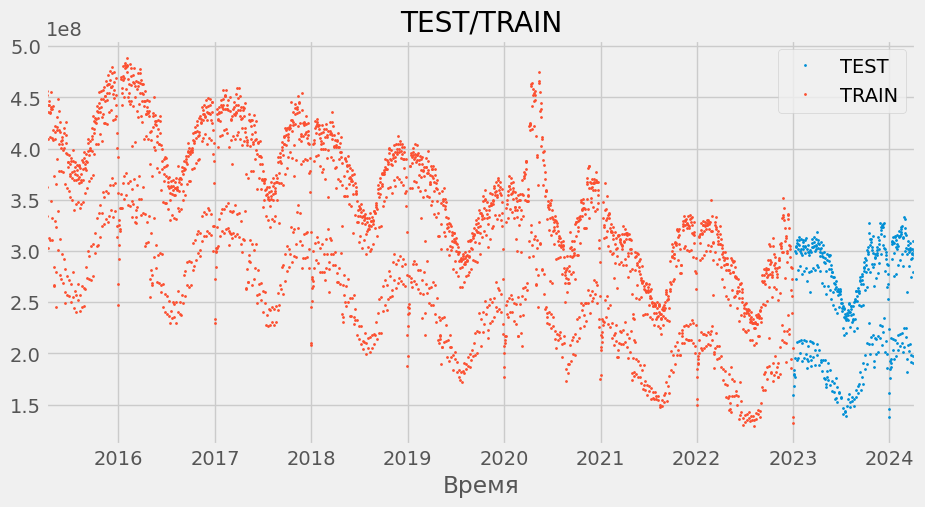

In [22]:
# Plot train and test so you can see where we have split
data_visits_desktop_test.name = 'TEST'
data_visits_desktop_train.name = 'TRAIN'

data_visits_desktop_test \
    .to_frame() \
    .join(data_visits_desktop_train, 
          how='outer').plot(figsize=(10, 5), title='TEST/TRAIN', style='.', ms=2)

plt.legend()
plt.show()

In [23]:
data_visits_desktop_train_prophet = data_visits_desktop_train.reset_index() \
    .rename(columns={'Время':'ds',
                     'TRAIN':'y'})
model2 = Prophet(holidays_prior_scale=0.001)
model2.add_country_holidays(country_name='RU')
model2.fit(data_visits_desktop_train_prophet)

17:35:13 - cmdstanpy - INFO - Chain [1] start processing
17:35:13 - cmdstanpy - INFO - Chain [1] done processing


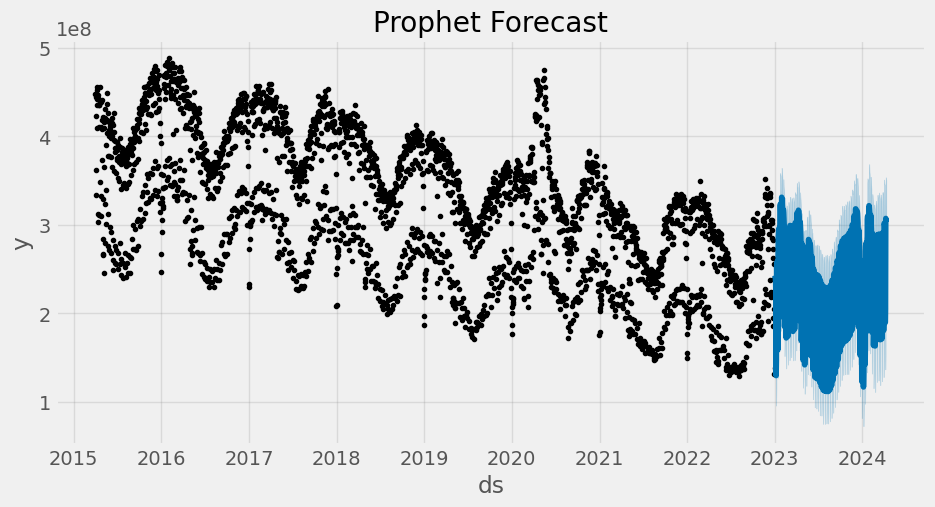

In [24]:
data_visits_desktop_test_prophet = data_visits_desktop_test.reset_index() \
    .rename(columns={'Время':'ds',
                     'TEST':'y'})

data_visits_desktop_test_fcst = model2.predict(data_visits_desktop_test_prophet)

fig, ax = plt.subplots(figsize=(10, 5))
fig = model2.plot(data_visits_desktop_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

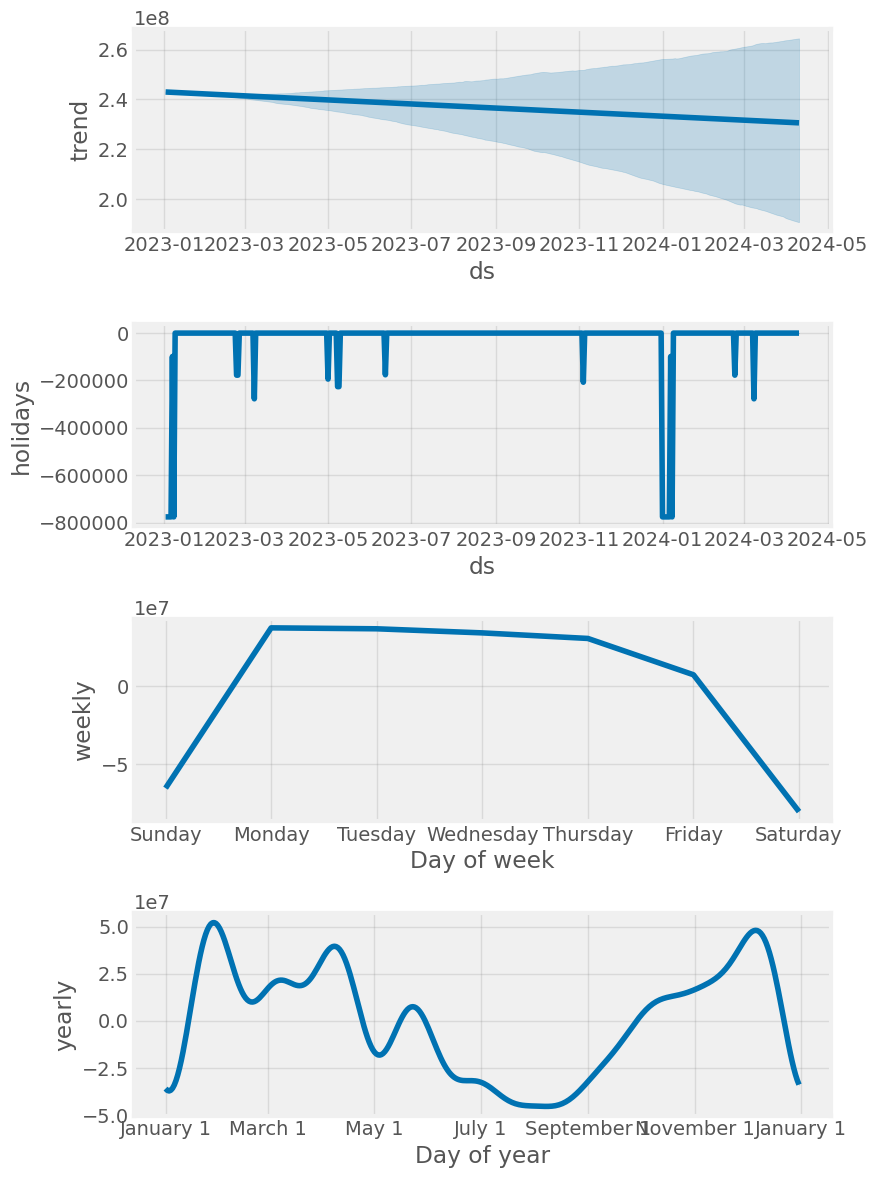

In [25]:
fig = model2.plot_components(data_visits_desktop_test_fcst)
plt.show()

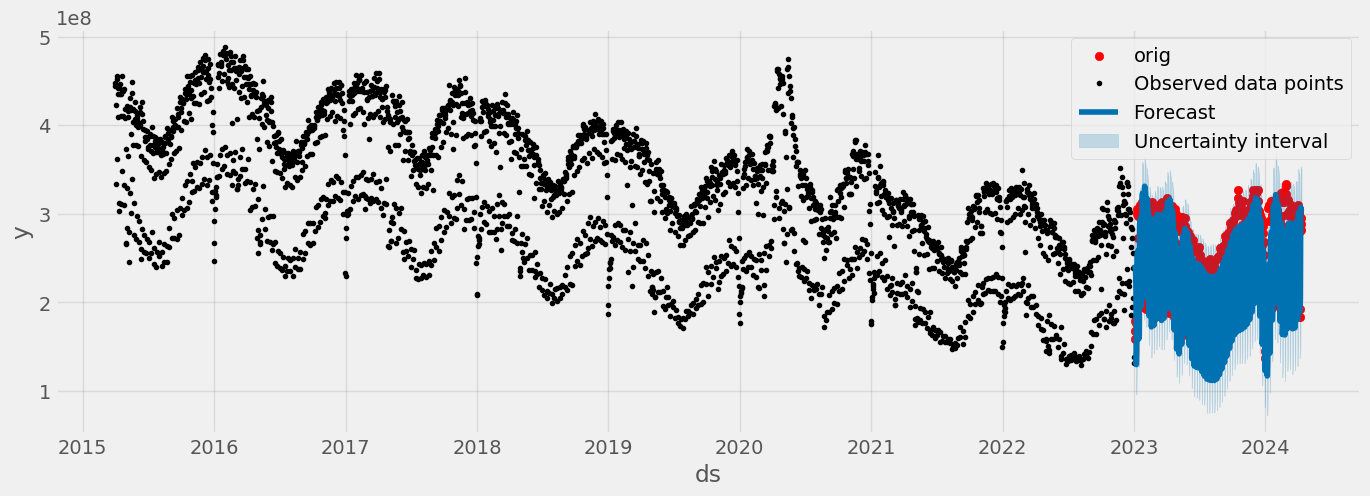

In [26]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_desktop_test.index, data_visits_desktop_test, color='r', label='orig')
fig = model2.plot(data_visits_desktop_test_fcst, ax=ax)

plt.legend()

In [27]:
np.sqrt(mean_squared_error(y_true=data_visits_desktop_test,
                   y_pred=data_visits_desktop_test_fcst['yhat']))

26333156.248167798

In [28]:
mean_absolute_error(y_true=data_visits_desktop_test,
                   y_pred=data_visits_desktop_test_fcst['yhat'])

20503435.977453317

In [29]:
mean_absolute_percentage_error(y_true=data_visits_desktop_test,
                   y_pred=data_visits_desktop_test_fcst['yhat'])

8.98156780945837

In [30]:
future2 = model2.make_future_dataframe(periods=365*4, freq='d', include_history=False)
forecast2 = model2.predict(future2)

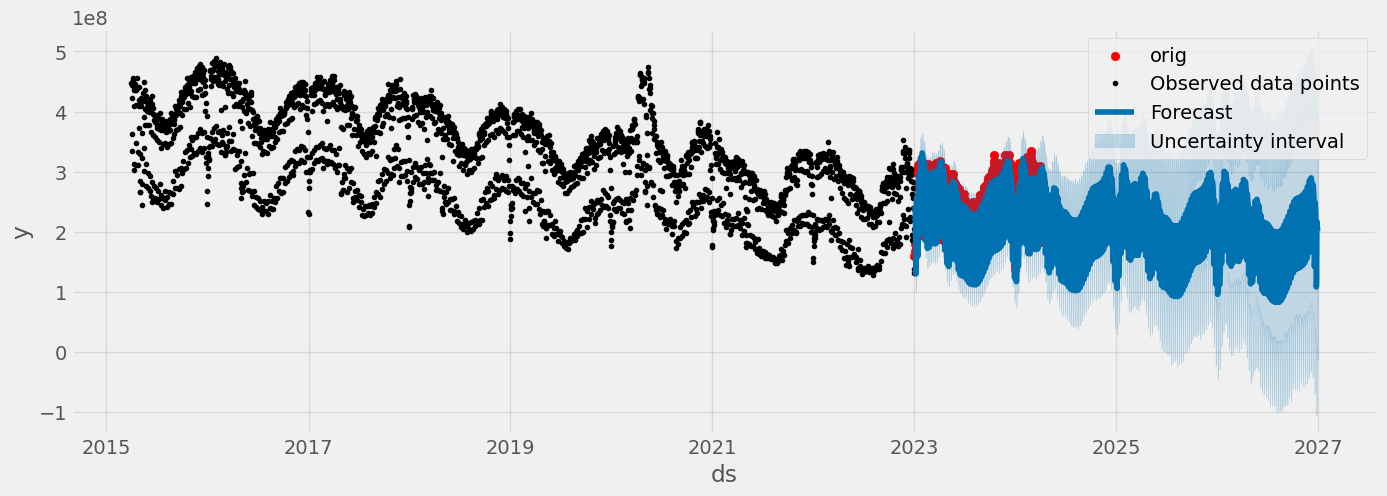

In [31]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_desktop_test.index, data_visits_desktop_test, color='r', label='orig')
fig = model2.plot(forecast2, ax=ax)

plt.legend()

In [32]:
#data_visits_desktop_index = forecast2.loc[forecast1['ds'] == '2025-01-01'].index
data_visits_desktop_2025 = forecast2.loc[forecast2['ds'] == '2025-01-01', 'yhat'].reset_index()
data_visits_desktop_2027 = forecast2.loc[forecast2.shape[0] - 1, 'yhat']
data_visits_desktop_2025

,index,yhat
0,730,2.207882e+08


# Планшеты

In [33]:
data_visits_tablet = data_visits.loc[:, 'Планшеты, Визиты']

split_date = '01.01.2023'

data_train = data_visits_tablet.loc[data_visits_tablet.index <= split_date].copy()
data_test = data_visits_tablet.loc[data_visits_tablet.index > split_date].copy()

# Plot train and test so you can see where we have split
data_visits_tablet_train = data_visits_tablet.loc[data_visits_tablet.index <= split_date].copy()
data_visits_tablet_test = data_visits_tablet.loc[data_visits_tablet.index > split_date].copy()

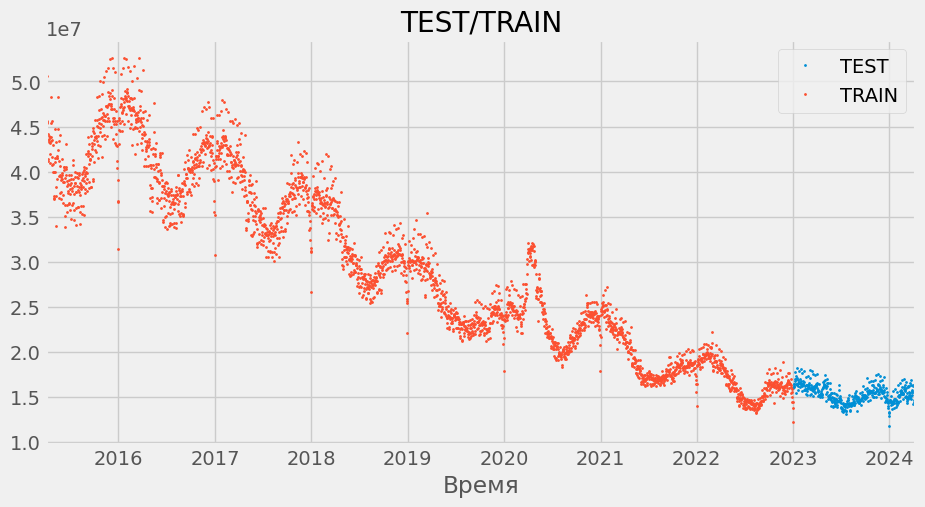

In [34]:
# Plot train and test so you can see where we have split
data_visits_tablet_test.name = 'TEST'
data_visits_tablet_train.name = 'TRAIN'

data_visits_tablet_test \
    .to_frame() \
    .join(data_visits_tablet_train, 
          how='outer').plot(figsize=(10, 5), title='TEST/TRAIN', style='.', ms=2)

plt.legend()
plt.show()

In [35]:
data_visits_tablet_train_prophet = data_visits_tablet_train.reset_index() \
    .rename(columns={'Время':'ds',
                     'TRAIN':'y'})
model3 = Prophet(holidays_prior_scale=0.001)
model3.add_country_holidays(country_name='RU')
model3.fit(data_visits_tablet_train_prophet)

17:35:16 - cmdstanpy - INFO - Chain [1] start processing
17:35:17 - cmdstanpy - INFO - Chain [1] done processing


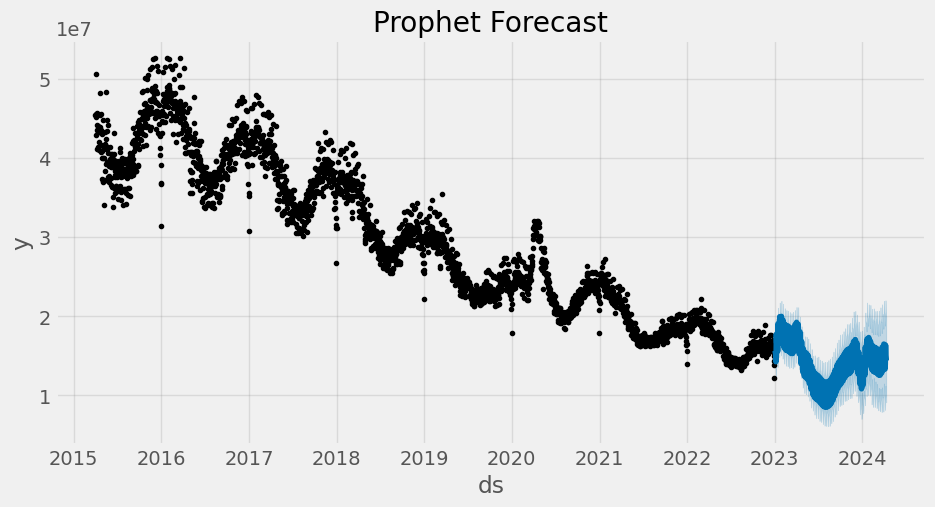

In [36]:
data_visits_tablet_test_prophet = data_visits_tablet_test.reset_index() \
    .rename(columns={'Время':'ds',
                     'TEST':'y'})

data_visits_tablet_test_fcst = model3.predict(data_visits_tablet_test_prophet)

fig, ax = plt.subplots(figsize=(10, 5))
fig = model3.plot(data_visits_tablet_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')

plt.show()

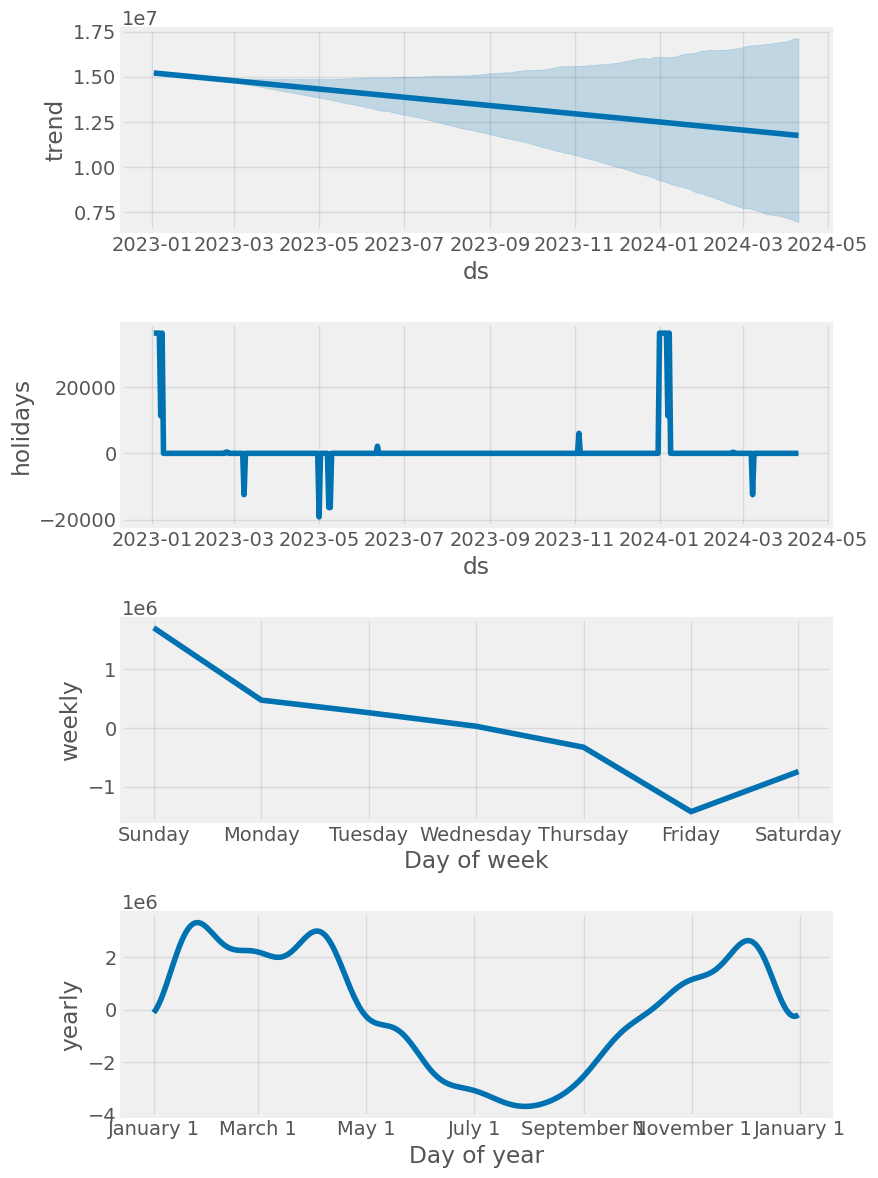

In [37]:
fig = model3.plot_components(data_visits_tablet_test_fcst)
plt.show()

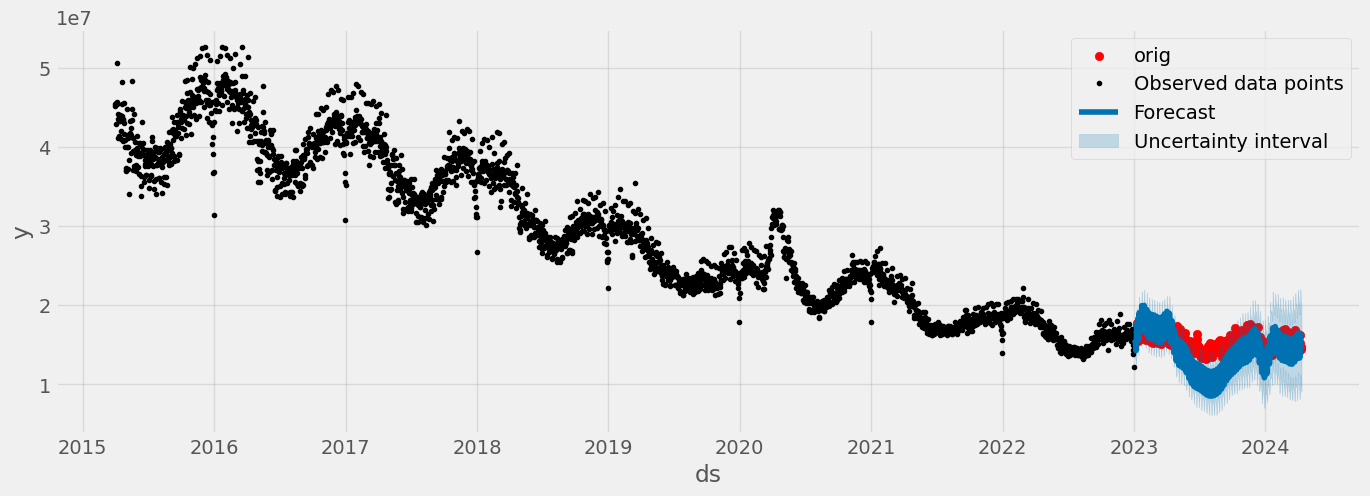

In [38]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_tablet_test.index, data_visits_tablet_test, color='r', label='orig')
fig = model3.plot(data_visits_tablet_test_fcst, ax=ax)

plt.legend()

In [39]:
np.sqrt(mean_squared_error(y_true=data_visits_tablet_test,
                   y_pred=data_visits_tablet_test_fcst['yhat']))

2327067.0847689086

In [40]:
mean_absolute_error(y_true=data_visits_tablet_test,
                   y_pred=data_visits_tablet_test_fcst['yhat'])

1920030.7350482673

In [41]:
mean_absolute_percentage_error(y_true=data_visits_tablet_test,
                   y_pred=data_visits_tablet_test_fcst['yhat'])

12.782985376314132

In [42]:
future3 = model3.make_future_dataframe(periods=365*4, freq='d', include_history=False)
forecast3 = model3.predict(future3)

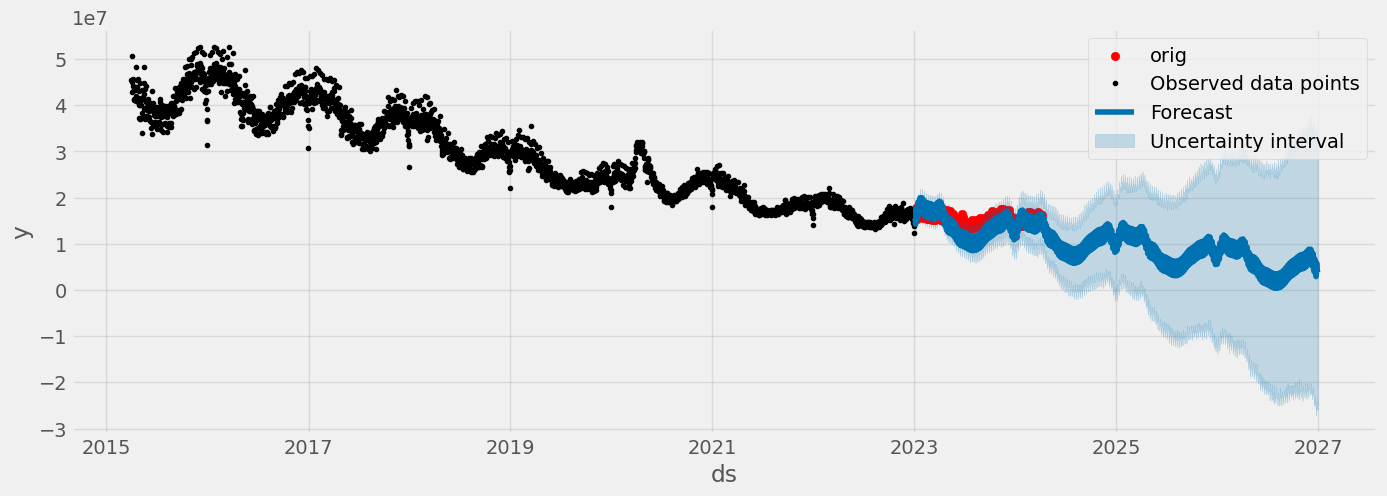

In [43]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_tablet_test.index, data_visits_tablet_test, color='r', label='orig')
fig = model3.plot(forecast3, ax=ax)

plt.legend()

In [44]:
forecast3.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Fatherland Defender's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1455,2026-12-27,4.381941e+06,-2.403897e+07,3.487044e+07,-2.578665e+07,3.382141e+07,0.0,0.0,0.0,0.0,...,1.708585e+06,1.708585e+06,1.708585e+06,-204866.277086,-204866.277086,-204866.277086,0.0,0.0,0.0,5.885660e+06
1456,2026-12-28,4.374499e+06,-2.450214e+07,3.349796e+07,-2.580457e+07,3.384220e+07,0.0,0.0,0.0,0.0,...,4.782687e+05,4.782687e+05,4.782687e+05,-242091.052546,-242091.052546,-242091.052546,0.0,0.0,0.0,4.610676e+06
1457,2026-12-29,4.367057e+06,-2.580081e+07,3.343092e+07,-2.582250e+07,3.386300e+07,0.0,0.0,0.0,0.0,...,2.640523e+05,2.640523e+05,2.640523e+05,-255514.036321,-255514.036321,-255514.036321,0.0,0.0,0.0,4.375595e+06
1458,2026-12-30,4.359615e+06,-2.576186e+07,3.318075e+07,-2.584457e+07,3.388380e+07,0.0,0.0,0.0,0.0,...,3.299556e+04,3.299556e+04,3.299556e+04,-244633.933889,-244633.933889,-244633.933889,0.0,0.0,0.0,4.147976e+06
1459,2026-12-31,4.352173e+06,-2.591562e+07,3.318969e+07,-2.589596e+07,3.390460e+07,0.0,0.0,0.0,0.0,...,-3.243747e+05,-3.243747e+05,-3.243747e+05,-209353.732472,-209353.732472,-209353.732472,0.0,0.0,0.0,3.818444e+06


In [45]:
#data_visits_tablet_index = forecast3.loc[forecast3['ds'] == '2025-01-01'].index
data_visits_tablet_2025 = forecast3.loc[forecast3['ds'] == '2025-01-01', 'yhat'].reset_index()
data_visits_tablet_2027 = forecast3.loc[forecast3.shape[0] - 1, 'yhat']
data_visits_tablet_2025

,index,yhat
0,730,9.735280e+06


In [46]:
smartphone_proportion_2025 = data_visits_smartphone_2025['yhat'] / (data_visits_smartphone_2025['yhat'] + data_visits_desktop_2025['yhat'] + data_visits_tablet_2025['yhat'])
smartphone_proportion_2025 * 100

0    70.838682
Name: yhat, dtype: float64

In [47]:
data_visits_2027 = data_visits_tablet_2027 + data_visits_smartphone_2027 + data_visits_desktop_2027
smartphone_proportion_2027 = (data_visits_smartphone_2027 / data_visits_2027)
smartphone_proportion_2027 * 100

75.20977710052671

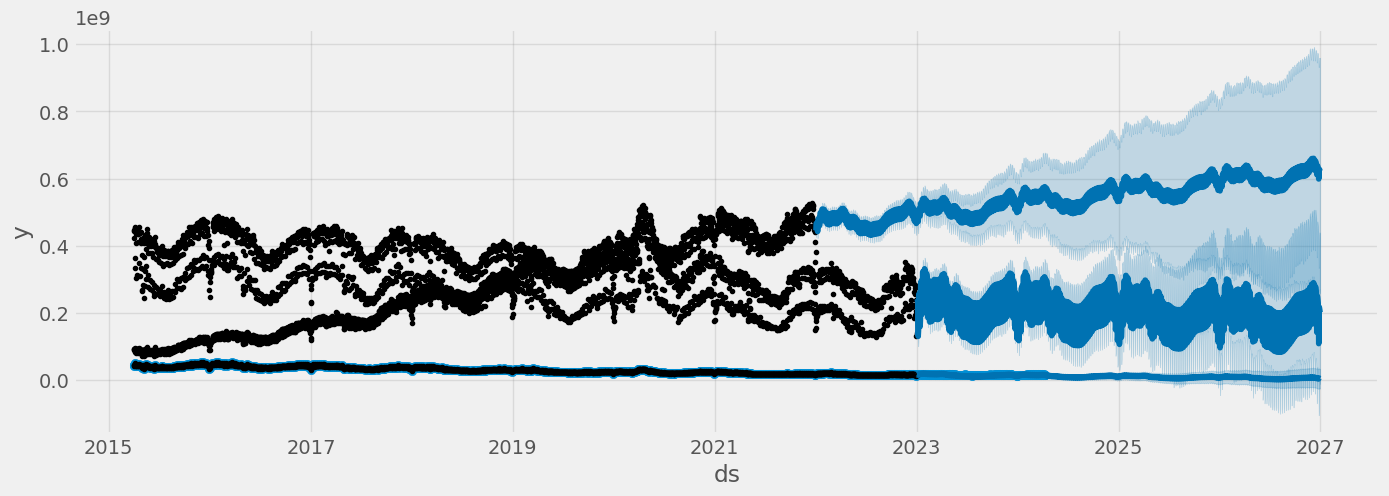

In [48]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_visits_tablet.index, data_visits_tablet)
fig = model3.plot(forecast3, ax=ax)


#ax.scatter(data_visits_tablet.index, data_visits_desktop, label='orig')
fig = model2.plot(forecast2, ax=ax)


#ax.scatter(data_visits_tablet.index, data_visits_smartphone, label='orig')
fig = model1.plot(forecast1, ax=ax)

#plt.legend()

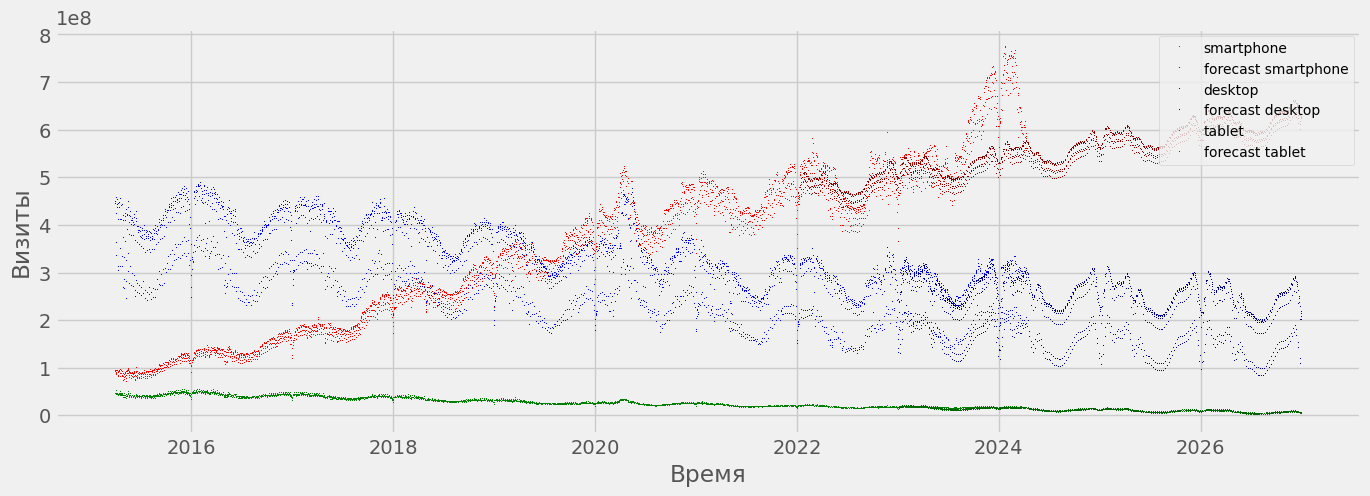

In [50]:
plt.figure(figsize=(15, 5))
plt.rc('lines', ls='', marker=',')

plt.plot(data_visits_smartphone.index, data_visits_smartphone, label='smartphone', color='r')
plt.plot(forecast1['ds'], forecast1['yhat'], label='forecast smartphone', color='darkred')

plt.plot(data_visits_desktop.index, data_visits_desktop, label='desktop', color='b')
plt.plot(forecast2['ds'], forecast2['yhat'], label='forecast desktop', color='darkblue')

plt.plot(data_visits_tablet.index, data_visits_tablet, label='tablet', color='g')
plt.plot(forecast3['ds'], forecast3['yhat'], label='forecast tablet', color='darkgreen')

plt.xlabel('Время')
plt.ylabel('Визиты')

plt.legend(fontsize=10,loc='upper right')
plt.show()